In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numba import njit, prange
from quantecon.optimize import root_finding
%matplotlib inline

In [17]:
#=========== Class: BCG for complete markets ===========#
class BCG_complete_markets:
# init method or constructor
    def __init__(self,
                    chi1    = 0,
                    chi2    = 0.9,
                    w10     = 1,
                    w20     = 1,
                    theta10 = 0.5,
                    theta20 = 0.5,
                    psi     = 3,
                    alpha   = 0.6,
                    A       = 2.5,
                    mu      = -0.025,
                    sigma   = 0.4,
                    beta    = 0.96,
                    nb_points_integ = 10):
        #=========== Setup ===========#
        # Risk parameters
        self.chi1 = chi1
        self.chi2 = chi2
        # Other parameters
        self.psi   = psi 
        self.alpha = alpha
        self.A     = A
        self.mu    = mu
        self.sigma = sigma
        self.beta  = beta
        # Utility
        self.u = lambda c: (c**(1-psi)) / (1-psi)
        # Production
        self.f = njit(lambda k: A * (k ** alpha))
        self.Y = lambda eps, k: np.exp(eps) * self.f(k)
        # Initial endowments
        self.w10 = w10
        self.w20 = w20
        self.w0  = w10 + w20
        # Initial holdings
        self.theta10 = theta10
        self.theta20 = theta20
        # Endowments at t=1
        w11 = njit(lambda eps: np.exp(-chi1*mu - 0.5*(chi1**2)*(sigma**2) + chi1*eps))
        w21 = njit(lambda eps: np.exp(-chi2*mu - 0.5*(chi2**2)*(sigma**2) + chi2*eps))
        self.w11 = w11
        self.w21 = w21
        self.w1 = njit(lambda eps: w11(eps) + w21(eps))

        # Normal PDF
        self.g = lambda x: norm.pdf(x, loc=mu, scale=sigma)

        # Integration
        x, self.weights = np.polynomial.hermite.hermgauss(nb_points_integ)
        self.points_integral = np.sqrt(2) * sigma * x + mu
        self.k_foc = k_foc_factory(self)

    #=========== Optimal k ===========#
    # Function: solve for optimal k
    def opt_k(self, plot=False):
        w0 = self.w0
        # Grid for k
        kgrid = np.linspace(1e-4, w0-1e-4, 100)
        # get FONC values for each k in the grid
        kfoc_list = [];
        for k in kgrid:
            kfoc = self.k_foc(k, self.chi1, self.chi2)
            kfoc_list.append(kfoc)
        # Plot FONC for k
        if plot:
            fig, ax = plt.subplots(figsize=(8,7))
            ax.plot(kgrid, kfoc_list, color='blue', label=r'FONC for k')
            ax.axhline(0, color='red', linestyle='--')
            ax.legend()
            ax.set_xlabel(r'k')
            plt.show()
        # Find k that solves the FONC
        kk = root_finding.newton_secant(self.k_foc, 1e-2, args=(self.chi1, self.chi2)).root
        return kk
    #=========== Arrow security price ===========#
    # Function: Compute Arrow security price
    def q(self,eps,k):
        beta= self.beta
        psi= self.psi
        w0 = self.w0
        w1 = self.w1
        fk = self.f(k)
        g = self.g
        return  beta * ((w1(eps) + np.exp(eps)*fk) / (w0 - k))**(-psi)
    #=========== Firm value V ===========#
    # Function: compute firm value V
    def V(self, k):
        q = self.q
        fk = self.f(k)
        weights = self.weights
        integ = lambda eps: np.exp(eps) * fk * q(eps, k)
        return -k + np.sum(weights * integ(self.points_integral)) / np.sqrt(np.pi)
    #=========== Optimal c ===========#
    # Function: Compute optimal consumption choices c
    def opt_c(self, k=None, plot=False):
        w1 = self.w1
        w0 = self.w0
        w10 = self.w10
        w11 = self.w11
        theta10 = self.theta10
        Y = self.Y
        q = self.q
        V = self.V
        weights = self.weights
        if k is None:
            k = self.opt_k()
        # Solve for the ratio of consumption  from the intertemporal B.C.
        fk = self.f(k)
        c1 = lambda eps: (w1(eps) + np.exp(eps)*fk)*q(eps,k)
        denom = np.sum(weights * c1(self.points_integral)) / np.sqrt(np.pi) + (w0 - k)
        w11q = lambda eps: w11(eps)*q(eps,k)
        num = w10 + theta10 * V(k) + np.sum(weights * w11q(self.points_integral)) / np.sqrt(np.pi)
        eta = num / denom
        # Consumption choices
        c10 =  eta * (w0 - k)
        c20 = (1-eta ) * (w0 - k)
        c11 = lambda eps: eta * (w1(eps)+Y(eps,k))
        c21 = lambda eps: (1-eta) * (w1(eps)+Y(eps,k))
        return c10, c20, c11, c21

def k_foc_factory(model):
    psi     = model.psi
    f       = model.f
    beta    = model.beta
    alpha   = model.alpha
    A       = model.A
    psi     = model.psi
    w0      = model.w0
    mu      = model.mu
    sigma   = model.sigma

    weights = model.weights
    points_integral = model.points_integral

    w11 = njit(lambda eps, chi1: np.exp(-chi1*mu - 0.5*(chi1**2)*(sigma**2) + chi1*eps))
    w21 = njit(lambda eps, chi2: np.exp(-chi2*mu - 0.5*(chi2**2)*(sigma**2) + chi2*eps))
    w1  = njit(lambda eps, chi1, chi2: w11(eps, chi1) + w21(eps, chi2))

    @njit
    def integrand(eps, chi1, chi2, k=1e-4):
        fk = f(k)
        return (w1(eps, chi1, chi2) + np.exp(eps) * fk) ** (-psi) * np.exp(eps)
    
    @njit
    def k_foc(k, chi1, chi2):
        int_k = np.sum(weights * integrand(points_integral, chi1, chi2, k=k)) / np.sqrt(np.pi)
        mul = beta * alpha * A * k ** (alpha - 1) / ((w0 - k) ** (-psi))
        val = mul * int_k - 1
        return val
    return k_foc    

In [18]:
# Example: BCG model for complete markets
mdl1 = BCG_complete_markets()
mdl2 = BCG_complete_markets(chi2=-0.9)

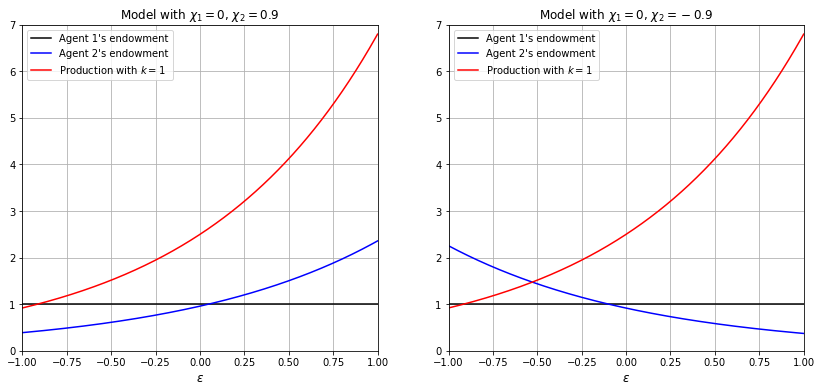

In [19]:
#==== Figure 1: HH endowments and firm productivity ====#
# Realizations of innovation from -3 to 3
epsgrid = np.linspace(-1,1,1000)
fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(epsgrid, mdl1.w11(epsgrid), color='black', label='Agent 1\'s endowment')
ax[0].plot(epsgrid, mdl1.w21(epsgrid), color='blue', label='Agent 2\'s endowment')
ax[0].plot(epsgrid, mdl1.Y(epsgrid,1), color='red', label=r'Production with $k=1$')
ax[0].set_xlim([-1,1])
ax[0].set_ylim([0,7])
ax[0].set_xlabel(r'$\epsilon$',fontsize=12)
ax[0].set_title(r'Model with $\chi_1 = 0$, $\chi_2 = 0.9$')
ax[0].legend()
ax[0].grid()
ax[1].plot(epsgrid, mdl2.w11(epsgrid), color='black', label='Agent 1\'s endowment')
ax[1].plot(epsgrid, mdl2.w21(epsgrid), color='blue', label='Agent 2\'s endowment')
ax[1].plot(epsgrid, mdl2.Y(epsgrid,1), color='red', label=r'Production with $k=1$')
ax[1].set_xlim([-1,1])
ax[1].set_ylim([0,7])
ax[1].set_xlabel(r'$\epsilon$',fontsize=12)
ax[1].set_title(r'Model with $\chi_1 = 0$, $\chi_2 = -0.9$')
ax[1].legend()
ax[1].grid()
plt.show()

In [20]:
#print optimal k
kk_1 = mdl1.opt_k()
kk_2 = mdl2.opt_k()
print('The optimal k for model 1: {:.5f}'.format(kk_1))
print('The optimal k for model 2: {:.5f}'.format(kk_2))
# Print optimal time-0 consumption for agent 2
c20_1 = mdl1.opt_c(k=kk_1)[1]
c20_2 = mdl2.opt_c(k=kk_2)[1]
print('The optimal c20 for model 1: {:.5f}'.format(c20_1))
print('The optimal c20 for model 2: {:.5f}'.format(c20_2))

The optimal k for model 1: 0.14235
The optimal k for model 2: 0.13791
The optimal c20 for model 1: 0.90205
The optimal c20 for model 2: 0.92862


In [22]:
# Mesh grid of 
N = 30
chi1grid, chi2grid = np.meshgrid(np.linspace(-1,1,N),
                                 np.linspace(-1,1,N))
k_foc = k_foc_factory(mdl1)

# Create grid for k
kgrid = np.zeros_like(chi1grid)

w0 = mdl1.w0

@njit(parallel=True)
def fill_k_grid(kgrid):
    # Loop: Compute optimal k and
    for i in prange(N):
        for j in prange(N):
            X1 = chi1grid[i, j]
            X2 = chi2grid[i, j]
            k = root_finding.newton_secant(k_foc,1e-2,args=(X1,X2)).root
            kgrid[i,j]=k

#time
fill_k_grid(kgrid)

In [23]:
#second run
fill_k_grid(kgrid)

In [24]:
#=== Example: Plot optimal k with different correlations ===#
from IPython.display import Image
# Import plotly
import plotly.graph_objs as go
# Plot optimal k
fig = go.Figure(data=[go.Surface(x=chi1grid, y=chi2grid, z=kgrid)])
fig.update_layout(scene = dict(xaxis_title='x - chi1',
                                yaxis_title='y - chi2',
                                zaxis_title='z - k',
                                aspectratio=dict(x=1,y=1,z=1)))
fig.update_layout(width=500,
                    height=500,
                    margin=dict(l=50, r=50, b=65, t=90))
fig.update_layout(scene_camera=dict(eye=dict(x=2, y=-2, z=1.5)))
# Export to PNG file
# Image(fig.to_image(format="png"))
# fig.show() will 